# 6. EDA（探索的データ分析）と特徴量選択

## 概要
本Notebookでは、電力需要・太陽光発電量予測モデルの精度向上のため、気象データやカレンダー情報を外部特徴量として追加し、探索的データ分析（EDA）と特徴量選択を行う。

### 6-1. 目的

本ノートブックの目的は、予測モデルの精度向上に寄与する外部特徴量を特定することである。

前工程で構築したベースラインモデルは、過去の時系列パターンのみを学習に用いた。その結果、電力消費量予測では一定の精度が得られたものの、天候など外部要因に強く依存する太陽光発電量予測の精度は不十分であった。

この課題を解決するため、本工程では新たに気象データやカレンダー情報を特徴量として追加し、目的変数（発電量・消費量）との関係性を分析する。分析を通じて得られた知見に基づき、以下の多角的なアプローチでモデルの学習に有効な特徴量を選択する。

1.  **相関分析**: 各特徴量と目的変数の線形関係を評価し、全体像を把握する。
2.  **LASSO回帰**: L1正則化により、予測への寄与が小さい特徴量の係数をゼロ化し、多重共線性を回避しつつ有効な変数を絞り込む。
3.  **LASSO正則化パスの可視化**: 正則化の強度（$\alpha$）とモデル誤差、選択される特徴量数の関係を可視化し、変数選択プロセスの妥当性を検証する。
4.  **LightGBM + SHAP**: LASSOで選択した特徴量を用い、非線形な関係も捉えられるLightGBMモデルを構築。SHAP値によって各特徴量が予測に与える影響の大きさと方向性（正負）を評価し、解釈性を深める。

## 6-2. データの準備

### 6-2-1. データの出典
本分析で使用するデータは以下の通りである。

- **電力需給データ**:
    - 提供元: TEPCO Power Grid
    - 内容: 東京電力パワーグリッドエリアの30分ごとの電力需給実績。
    - URL: [https://www.tepco.co.jp/pg/consignment/results/supply-demand.html](https://www.tepco.co.jp/pg/consignment/results/supply-demand.html)

- **気象データ**:
    - 提供元: 気象庁
    - 内容: 東京の気象観測データ（気温、降水量、日照時間など）。
    - URL: [https://www.data.jma.go.jp/gmd/risk/obsdl/](https://www.data.jma.go.jp/gmd/risk/obsdl/)

#### データ説明補足

* 気象情報は予測不能、周期関数と祝日は先読みをしても良いことに注意

* 気象データ列名　日本語
"気圧（現地）","気圧（海面）","降水量","気温","露点湿度","蒸気圧",
 "湿度","風速","風向","日照時間","全天日射量","降雪","積雪",

* 不要列を削除した気象データ列名 英語
"pressure_local", "pressure_sea", "precipitation", "temperature", "dew_point", "vapor_pressure", "humidity", "wind_speed", "sunshine_duration", "solar_radiation"									

* 1時間毎の気象データを線形補間し、30分間隔に加工して使用。　

    ```python
    df.resample('30T').interpolate(method='linear')
    ```

In [1]:
# ライブラリのインポート

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from tqdm.notebook import tqdm
import itertools
import warnings

# 共通モジュールのインポート
from src.data_utils import load_timeseries_data, validate_no_missing

# スタイル設定
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams['font.family'] = 'Meiryo' # Windowsの場合。Macの場合は 'Hiragino Sans' など

# 警告を非表示
warnings.filterwarnings('ignore')

In [2]:
# load data
BASE_DIR = Path().resolve()
DATA_DIR = BASE_DIR.parent / "data"
target_file = DATA_DIR / "e_gen_demand.csv"

df = load_timeseries_data(target_file)
df.head()

,solar_gen_mw,e_demand_mw
datetime,,
2023-01-01 00:00:00,0,29870
2023-01-01 00:30:00,0,28640
2023-01-01 01:00:00,0,27560
2023-01-01 01:30:00,0,27240
2023-01-01 02:00:00,0,26650


In [3]:
# 気象データの読み込みと欠損チェック
weather_csv = DATA_DIR / "weather_data.csv"
dfw = load_timeseries_data(weather_csv)
validate_no_missing(dfw)
dfw.head()

Missing value check completed: No missing values in any column


,pressure_local,precipitation,temperature,dew_point,vapor_pressure,humidity,wind_speed,sunshine_duration,solar_radiation
datetime,,,,,,,,,
2023-01-01 00:00:00,1018.20,0.0,3.80,-0.60,5.9,73.0,1.80,0.0,0.0
2023-01-01 00:30:00,1018.05,0.0,3.65,-0.55,5.9,74.0,1.40,0.0,0.0
2023-01-01 01:00:00,1017.90,0.0,3.50,-0.50,5.9,75.0,1.00,0.0,0.0
2023-01-01 01:30:00,1018.00,0.0,3.35,-0.75,5.8,74.5,1.15,0.0,0.0
2023-01-01 02:00:00,1018.10,0.0,3.20,-1.00,5.7,74.0,1.30,0.0,0.0


In [4]:
if 'pressure_sea' in dfw.columns:
    weather_data = dfw.drop(columns=['pressure_sea'])
else:
    # 列がない場合はそのまま
    weather_data = dfw.copy() 
    
# 結果をCSVファイルとして保存
weather_data.to_csv('../data/weather_data.csv', encoding='utf-8')

### 6-2-2. 特徴量エンジニアリング

予測モデルの表現力を高めるため、以下の特徴量を作成する。

-   **周期性特徴量**: 時間や曜日の周期性をモデルが学習しやすくするため、`hour`と`weekday`を`sin/cos`変換した特徴量（`sin_hour`, `cos_hour`, `sin_weekday`, `cos_weekday`）を作成する。
-   **休日特徴量**: 内閣府提供の祝日データに基づき、土日・祝日・年末年始を「休日」とするフラグ（`is_holiday`）を作成する。

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime, date

def create_extended_holiday_feature(df):
 # 祝日データの取得
 holiday_df = pd.read_csv('https://www8.cao.go.jp/chosei/shukujitsu/syukujitsu.csv',
 encoding='shift_jis',
 parse_dates=['国民の祝日・休日月日'])
 
 # 祝日データをセット化
 holiday_dates = set(holiday_df['国民の祝日・休日月日'].dt.date)
 
 # 年末年始の休暇日を追加する関数
 def is_yearend_holiday(d):
    month = d.month
    day = d.day
    return ((month == 12 and day >= 30) or 
    (month == 1 and day <= 3))
 
 # 土日と祝日と年末年始を判定
 df['is_holiday'] = df.index.map(lambda x: 
 1 if (x.weekday() >= 5 or 
 x.date() in holiday_dates or 
 is_yearend_holiday(x)) else 0)
 
 # 周期性特徴量の作成
 hours = df.index.hour
 df['sin_hour'] = np.sin(2 * np.pi * hours/24)
 df['cos_hour'] = np.cos(2 * np.pi * hours/24)
 
 weekdays = df.index.weekday
 df['sin_weekday'] = np.sin(2 * np.pi * weekdays/7)
 df['cos_weekday'] = np.cos(2 * np.pi * weekdays/7)
 
 # 結果を保存
 holiday_features = df[['sin_hour', 'cos_hour', 
 'sin_weekday', 'cos_weekday', 
 'is_holiday']]
 holiday_features.to_csv('../data/sincos_holiday.csv')
 
 return df

# 実行
df_extended = create_extended_holiday_feature(df)

# 年末年始の休暇日が正しく判定されているか確認
check_dates = [
 '2024-12-30', '2024-12-31', '2025-01-02', '2025-01-03'
]
print("\n年末年始の休暇日チェック:")
for d in check_dates:
 if d in df_extended.index:
    print(f"{d}: is_holiday = {df_extended.loc[d, 'is_holiday']}")

df_extended.head()


年末年始の休暇日チェック:
2024-12-30: is_holiday = datetime
2024-12-30 00:00:00    1
2024-12-30 00:30:00    1
2024-12-30 01:00:00    1
2024-12-30 01:30:00    1
2024-12-30 02:00:00    1
2024-12-30 02:30:00    1
2024-12-30 03:00:00    1
2024-12-30 03:30:00    1
2024-12-30 04:00:00    1
2024-12-30 04:30:00    1
2024-12-30 05:00:00    1
2024-12-30 05:30:00    1
2024-12-30 06:00:00    1
2024-12-30 06:30:00    1
2024-12-30 07:00:00    1
2024-12-30 07:30:00    1
2024-12-30 08:00:00    1
2024-12-30 08:30:00    1
2024-12-30 09:00:00    1
2024-12-30 09:30:00    1
2024-12-30 10:00:00    1
2024-12-30 10:30:00    1
2024-12-30 11:00:00    1
2024-12-30 11:30:00    1
2024-12-30 12:00:00    1
2024-12-30 12:30:00    1
2024-12-30 13:00:00    1
2024-12-30 13:30:00    1
2024-12-30 14:00:00    1
2024-12-30 14:30:00    1
2024-12-30 15:00:00    1
2024-12-30 15:30:00    1
2024-12-30 16:00:00    1
2024-12-30 16:30:00    1
2024-12-30 17:00:00    1
2024-12-30 17:30:00    1
2024-12-30 18:00:00    1
2024-12-30 18:30:00    1
2

,solar_gen_mw,e_demand_mw,is_holiday,sin_hour,cos_hour,sin_weekday,cos_weekday
datetime,,,,,,,
2023-01-01 00:00:00,0,29870,1,0.000000,1.000000,-0.781831,0.62349
2023-01-01 00:30:00,0,28640,1,0.000000,1.000000,-0.781831,0.62349
2023-01-01 01:00:00,0,27560,1,0.258819,0.965926,-0.781831,0.62349
2023-01-01 01:30:00,0,27240,1,0.258819,0.965926,-0.781831,0.62349
2023-01-01 02:00:00,0,26650,1,0.500000,0.866025,-0.781831,0.62349


In [6]:
# 2つのdf df_extended, weather_data の欠損値チェックと日付の最大最小確認

dataframes = {
 'df_extended': df_extended,
 'weather_data': weather_data
}

for name, dataframe in dataframes.items():
    print(f"\nDataFrame: {name}")
    print("欠損値チェック:")
    print(dataframe.isnull().sum())
    print(f"日付の最小: {dataframe.index.min()}")
    print(f"日付の最大: {dataframe.index.max()}") 
 


DataFrame: df_extended
欠損値チェック:
solar_gen_mw    0
e_demand_mw     0
is_holiday      0
sin_hour        0
cos_hour        0
sin_weekday     0
cos_weekday     0
dtype: int64
日付の最小: 2023-01-01 00:00:00
日付の最大: 2025-03-31 23:30:00

DataFrame: weather_data
欠損値チェック:
pressure_local       0
precipitation        0
temperature          0
dew_point            0
vapor_pressure       0
humidity             0
wind_speed           0
sunshine_duration    0
solar_radiation      0
dtype: int64
日付の最小: 2023-01-01 00:00:00
日付の最大: 2025-04-01 00:00:00


In [7]:
# この結果から　df_extendedのindex に合わせ結合
df_with_x = df_extended.join(weather_data, how='left')
# 欠損値再確認
print("\n結合後の欠損値チェック:")
print(df_with_x.isnull().sum())

# 説明変数付きの欠損無しdfを df_with_x として　../data に保存する。
df_with_x.to_csv('../data/df_with_x.csv', encoding='utf-8')


結合後の欠損値チェック:
solar_gen_mw         0
e_demand_mw          0
is_holiday           0
sin_hour             0
cos_hour             0
sin_weekday          0
cos_weekday          0
pressure_local       0
precipitation        0
temperature          0
dew_point            0
vapor_pressure       0
humidity             0
wind_speed           0
sunshine_duration    0
solar_radiation      0
dtype: int64


### 6-2-2. shift_y df （目的変数の日付をshiftしたDataFrame）の作成

時系列予測で説明変数を用いる場合、SARIMAX系など以外は 目的変数 y を時間をシフトさせたdf を作成しておくと、

訓練、予測、特徴量選択など各所でリークを起こす可能性が低下する。

シフト量は　Forecast Horizon　予測ホライゾン と呼ばれる事が多い。

In [8]:
# 目的変数 y を時間をシフト(48コマ）させたdf を作成
SHIFT_PERIOD = -48 # 未来の値を現在の行に持ってくる（予測目的）

# 目的変数をシフト
df_with_x['solar_shifted'] = df_with_x['solar_gen_mw'].shift(SHIFT_PERIOD)
df_with_x['demand_shifted'] = df_with_x['e_demand_mw'].shift(SHIFT_PERIOD)

# 元の目的変数列を削除（リーク防止のため）
df_shifted = df_with_x.drop(columns=['solar_gen_mw', 'e_demand_mw'])

# shift(-48) によって生じたデータセット末尾のNaN行を削除
# これらの行は、予測対象（シフト後のy）が未来に存在しないため学習に使用できない
df_shifted = df_shifted.dropna(subset=['solar_shifted', 'demand_shifted'])

# 欠損期間データカット後の行数確認
print(f"元の行数: {len(df_with_x)}")
print(f"シフト・欠損行カット後の行数: {len(df_shifted)}")

# 欠損値再確認
print("\n結合後の欠損値チェック:")
print(df_shifted.isnull().sum())

# 最終的なdfを保存
df_shifted.to_csv('../data/df_shifted.csv', encoding='utf-8')

print("\n'../data/df_shifted.csv' の最初の5行:")
print(df_shifted.head())

元の行数: 39408
シフト・欠損行カット後の行数: 39360

結合後の欠損値チェック:
is_holiday           0
sin_hour             0
cos_hour             0
sin_weekday          0
cos_weekday          0
pressure_local       0
precipitation        0
temperature          0
dew_point            0
vapor_pressure       0
humidity             0
wind_speed           0
sunshine_duration    0
solar_radiation      0
solar_shifted        0
demand_shifted       0
dtype: int64

'../data/df_shifted.csv' の最初の5行:
                     is_holiday  sin_hour  cos_hour  sin_weekday  cos_weekday  \
datetime                                                                        
2023-01-01 00:00:00           1  0.000000  1.000000    -0.781831      0.62349   
2023-01-01 00:30:00           1  0.000000  1.000000    -0.781831      0.62349   
2023-01-01 01:00:00           1  0.258819  0.965926    -0.781831      0.62349   
2023-01-01 01:30:00           1  0.258819  0.965926    -0.781831      0.62349   
2023-01-01 02:00:00           1  0.500000  0.866025

## 6-3. 特徴量選択の実践

電力データ（目的変数）と、気象・周期データ（説明変数）を結合した分析用データセットを用いて、特徴量選択を行う。
目的変数である「太陽光発電量（solar_gen_mw）」および「電力消費量（e_demand_mw）」それぞれに対し、前述のプロセス（相関分析→LASSO→SHAP）を適用する。

まず「太陽光発電量（solar_gen_mw）」から分析を開始する。

まずは「太陽光発電量（solar_gen_mw）」から分析を開始する。

### 6-3-1. 太陽光発電量 (`solar_gen_mw`) の特徴量選択

#### 6-3-1-1. 相関分析

目的変数と各説明変数の線形相関をヒートマップで可視化し、関係性の全体像を把握する。

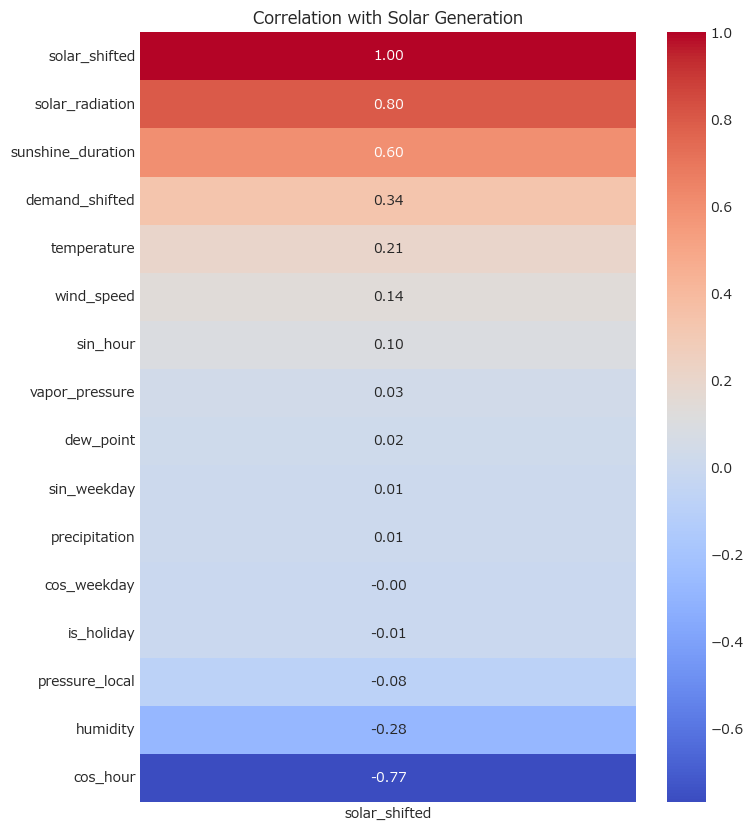

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ここから主対象がdf_shifted なので
df = df_shifted.copy()

# === 相関ヒートマップ ===
corr = df.corr(numeric_only=True)
plt.figure(figsize=(8,10))
sns.heatmap(
 corr[['solar_shifted']].sort_values(by='solar_shifted', ascending=False),
 annot=True, fmt=".2f", cmap="coolwarm"
)
plt.title("Correlation with Solar Generation")
plt.show()

**結果**: 予想通り、発電量（`solar_gen_mw`）は「全天日射量（`solar_radiation`）」および「日照時間（`sunshine_duration`）」と極めて強い正の相関（それぞれ 0.80, 0.60）を示した。また、「`cos_hour`」とも強い負の相関(-0.77)が見られる。

#### 6-3-1-2. LASSO回帰による変数選択

相関分析は変数間の1対1の関係しか評価できないため、次に全変数を投入した際の寄与度をLASSO回帰で評価する。時系列データであるため、クロスバリデーションには`TimeSeriesSplit`を使用し、未来のデータが過去の学習に使われないように配慮する。

solar_radiation      3064.424360
cos_hour            -1618.063072
sunshine_duration    -828.325214
temperature          -319.541750
sin_hour              296.826612
pressure_local       -221.714901
precipitation         160.945518
humidity              108.149498
wind_speed            -63.877518
sin_weekday            17.005293
dtype: float64

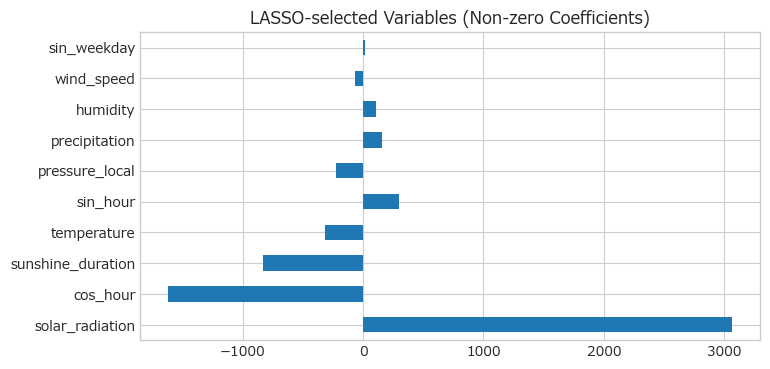

In [10]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# === 説明変数（例） ===
feature_cols = [
 "pressure_local","precipitation","temperature","dew_point","vapor_pressure",
 "humidity","wind_speed","sunshine_duration","solar_radiation",
 "sin_hour","cos_hour","sin_weekday","cos_weekday","is_holiday"
]
X = df[feature_cols]
y = df["solar_shifted"]

# === スケーリングと学習 ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tscv = TimeSeriesSplit(n_splits=5)
lasso = LassoCV(cv=tscv, random_state=0).fit(X_scaled, y)

# === 係数出力 ===
importance = pd.Series(lasso.coef_, index=feature_cols)
importance = importance[importance != 0].sort_values(key=abs, ascending=False)
display(importance)

plt.figure(figsize=(8,4))
importance.plot(kind='barh')
plt.title("LASSO-selected Variables (Non-zero Coefficients)")
plt.show()

**結果**: LASSOによって係数が0にならなかった（= 予測に寄与すると判断された）変数が選択された。`solar_radiation`が最も強い正の影響、`cos_hour`がそれに次ぐ影響を持つことが示された。

In [11]:
print(importance.index)

Index(['solar_radiation', 'cos_hour', 'sunshine_duration', 'temperature',
       'sin_hour', 'pressure_local', 'precipitation', 'humidity', 'wind_speed',
       'sin_weekday'],
      dtype='object')


LASSOによって係数が0にならなかった（= 予測に寄与すると判断された）変数がリストアップされる。

#### 6-3-1-3. LASSOの正則化パス（変数選択の過程）の可視化

`LassoCV`がクロスバリデーション（CV）を通じて、どのように最適な正則化強度（$\alpha$）を選択したかを可視化する。これにより、モデルの複雑さと予測誤差のトレードオフを検証する。

-   **CV曲線**: $\alpha$が大きくなる（正則化が強まる）につれてCV誤差（MSE）がどう変化するかを示す。選択された$\alpha$は、この誤差を最小化する点である。
-   **スパース性曲線**: $\alpha$が大きくなるにつれて、係数が0でない特徴量の数がどのように減少していくかを示す

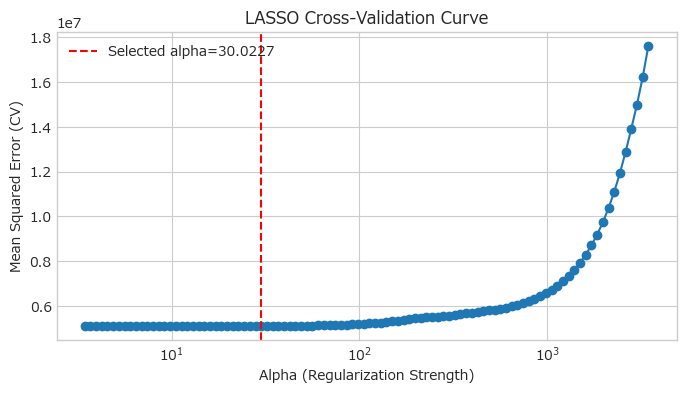

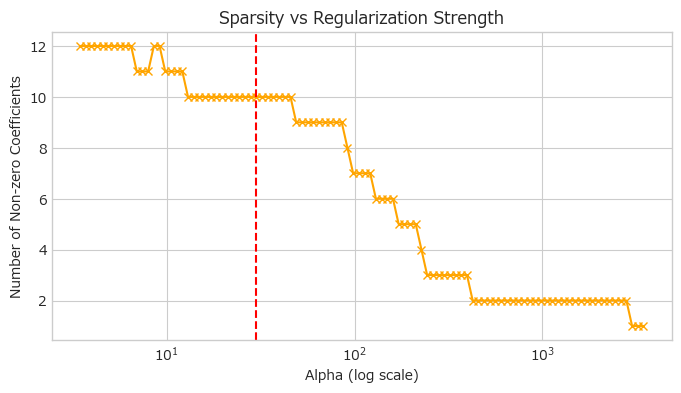

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.linear_model import lasso_path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

# === スケーリング済みデータ ===
# feature_colsは前のセルで定義されている想定です
feature_cols = [
 "pressure_local","precipitation","temperature","dew_point","vapor_pressure",
 "humidity","wind_speed","sunshine_duration","solar_radiation",
 "sin_hour","cos_hour","sin_weekday","cos_weekday","is_holiday"
]
X = df[feature_cols]
y = df["solar_shifted"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === TimeSeriesSplitを利用したLASSO CV ===
tscv = TimeSeriesSplit(n_splits=5)
# LassoCVで最適なalphaを見つける
lasso_cv = LassoCV(cv=tscv, random_state=0, n_alphas=100).fit(X_scaled, y)

# === alpha（lambda）と平均誤差の可視化 ===
plt.figure(figsize=(8,4))
plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_.mean(axis=-1), marker='o')
plt.axvline(lasso_cv.alpha_, color='red', linestyle='--', label=f"Selected alpha={lasso_cv.alpha_:.4f}")
plt.xscale('log')
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Mean Squared Error (CV)")
plt.title("LASSO Cross-Validation Curve")
plt.legend()
plt.grid(True)
plt.show()

# === 参考: alphaごとの係数のパスを計算 ===
# lasso_pathを使用して、係数のパスを取得します
alphas, coefs, _ = lasso_path(X_scaled, y, alphas=lasso_cv.alphas_)
nonzero_counts = (coefs != 0).sum(axis=0)
plt.figure(figsize=(8,4))
plt.plot(alphas, nonzero_counts, marker='x', color='orange')
plt.axvline(lasso_cv.alpha_, color='red', linestyle='--')
plt.xscale('log')
plt.xlabel("Alpha (log scale)")
plt.ylabel("Number of Non-zero Coefficients")
plt.title("Sparsity vs Regularization Strength")
plt.grid(True)
plt.show()

#### 6-3-1-4. LightGBM + SHAPによる特徴量重要度の評価

LASSOは線形性を仮定した変数選択手法である。そこで、LASSOで選択された変数が、非線形な関係も捉えられるLightGBMモデルにおいてどのような影響を持つか、SHAPを用いて評価する。これにより、各変数が予測値を押し上げる（赤）か、押し下げる（青）かを直感的に理解できる。

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1246
[LightGBM] [Info] Number of data points in the train set: 39360, number of used features: 10
[LightGBM] [Info] Start training from score 2887.014990


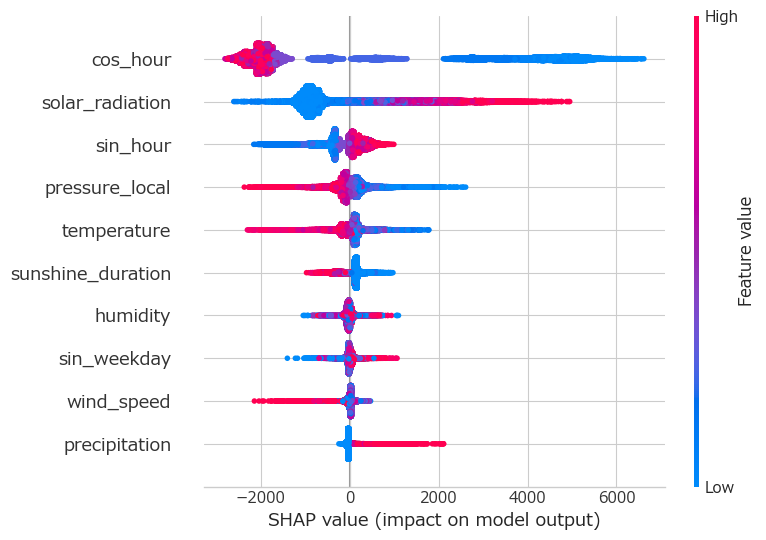

In [13]:
import pandas as pd
import lightgbm as lgb
import shap

# --- 修正後のコード ---

# === 1. LASSOで選択された特徴量のみを抽出 ===
# importanceは係数が0でない変数のSeries
selected_features = importance.index.tolist()
X_sel = X[selected_features]

# === 2. LightGBMモデルの学習 ===
model = lgb.LGBMRegressor(random_state=0)
model.fit(X_sel, y)

# === 3. SHAP解析と可視化（エラー修正版） ===
# Explainerをモデルのみで初期化します
explainer = shap.Explainer(model)

# SHAP値を計算します
shap_values = explainer(X_sel)

# SHAPのサマリープロットを表示します
# これで各変数が予測値に与える影響の大きさと方向がわかります
shap.summary_plot(shap_values, X_sel, show=True)

**結果**: SHAPのサマリープロットからも、`solar_radiation`が最も支配的な特徴量であることが確認できる。値が大きい（色が赤い）ほどSHAP値も大きくなり、予測値を強く押し上げている。

SHAPのサマリープロットにより、各変数が予測値に与える影響の大きさと方向（プラス/マイナス）が可視化される。

### 6-3-2. 電力需要量 (`e_demand_mw`) の特徴量選択

次に、目的変数を「電力消費量（e_demand_mw）」に変更し、太陽光発電量と同様のプロセスで特徴量選択を行う。 

#### 6-3-2-1. 相関分析

電力需要量は、冷暖房需要（気温・湿度）、時間帯（`sin/cos_hour`）、曜日や祝日（`is_holiday`）と相関が出ることが予想される。

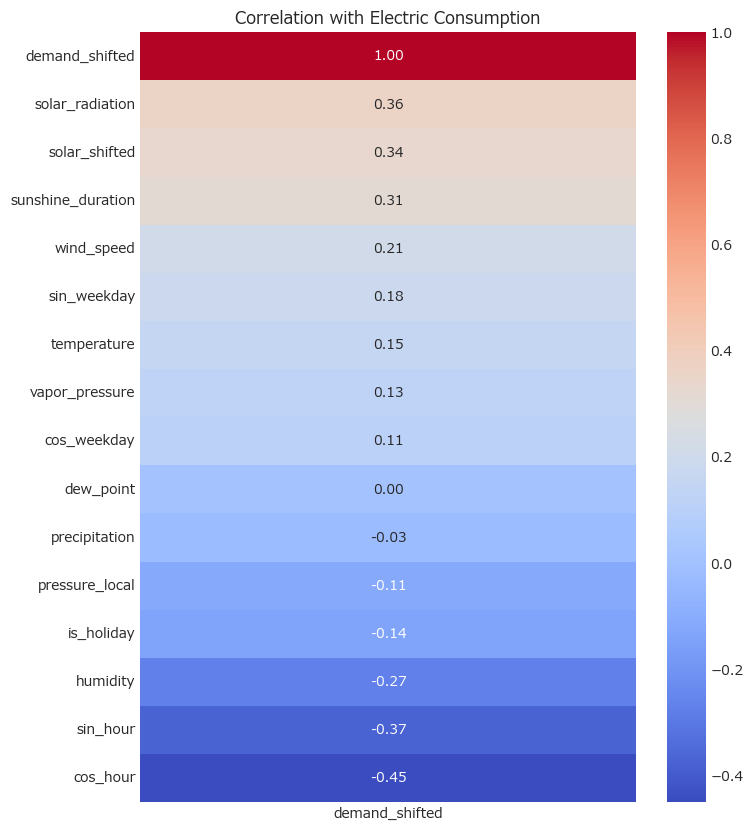

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# === 相関ヒートマップ ===
corr = df.corr(numeric_only=True)
plt.figure(figsize=(8,10))
sns.heatmap(
 corr[["demand_shifted"]].sort_values(by="demand_shifted", ascending=False),
 annot=True, fmt=".2f", cmap="coolwarm"
)
plt.title("Correlation with Electric Consumption")
plt.show()

**結果**: `solar_radiation`（全天日射量）などと正の相関を示したが、相関は発電量の時より弱い。また、活動時間帯を示す`cos_hour`とは負の相関（夜間に低く日中に高い需要）が見られる。

#### 6-3-2-2. LASSO回帰による変数選択と$\alpha$の調整

電力需要量に対しても、`LassoCV`と`TimeSeriesSplit`を用いて変数選択を行う。

cos_hour   -1352.649891
sin_hour    -803.857858
dtype: float64

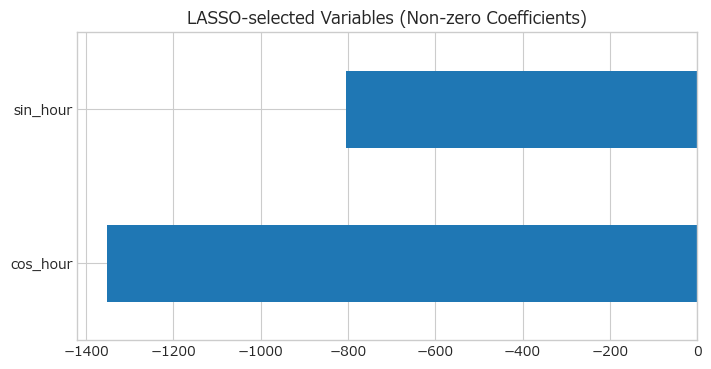

In [15]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# === 説明変数（例） ===
feature_cols = [
 "pressure_local","precipitation","temperature","dew_point","vapor_pressure",
 "humidity","wind_speed","sunshine_duration","solar_radiation",
 "sin_hour","cos_hour","sin_weekday","cos_weekday","is_holiday"
]
X = df[feature_cols]
y = df["demand_shifted"]

# === スケーリングと学習 ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tscv = TimeSeriesSplit(n_splits=5)
lasso = LassoCV(cv=tscv, random_state=0).fit(X_scaled, y)

# === 係数出力 ===
importance = pd.Series(lasso.coef_, index=feature_cols)
importance = importance[importance != 0].sort_values(key=abs, ascending=False)
display(importance)

plt.figure(figsize=(8,4))
importance.plot(kind='barh')
plt.title("LASSO-selected Variables (Non-zero Coefficients)")
plt.show()

#### 6-3-2-3. LASSOの正則化パス可視化と$\alpha$の調整

`LassoCV`による自動選択の結果、選択される変数が極端に少なくなり、モデルの表現力が不足する可能性が示唆された。これは、CV誤差の曲線が不安定な場合に起こりうる。

このような場合、自動選択された$\alpha$に固執するのではなく、分析者がドメイン知識や誤差と変数数のトレードオフを考慮して$\alpha$を調整することが有効である。ここでは、CV誤差が低く、かつより多くの変数をモデルに残せるよう、$\alpha$をより小さい値（`alpha_new = 30`）に手動で設定し、再度LASSOモデルを構築する。このアプローチにより、機械的な最適化の限界を補い、より現実的な特徴量セットを得ることを目指す。

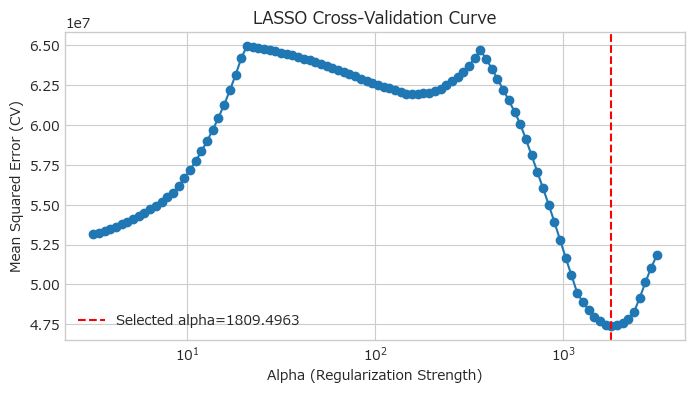

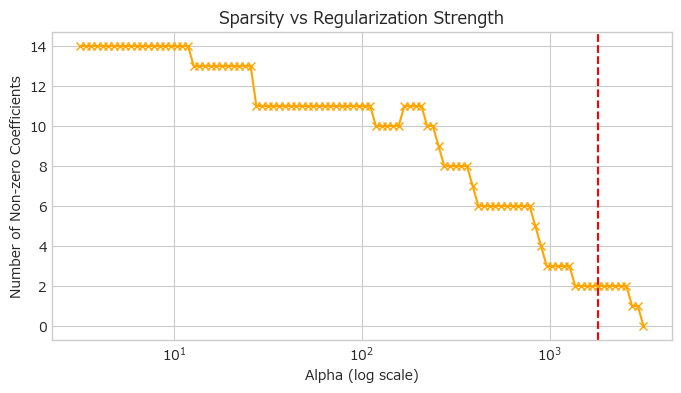

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.linear_model import lasso_path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

# === スケーリング済みデータ ===
# feature_colsは前のセルで定義されている想定です
feature_cols = [
 "pressure_local","precipitation","temperature","dew_point","vapor_pressure",
 "humidity","wind_speed","sunshine_duration","solar_radiation",
 "sin_hour","cos_hour","sin_weekday","cos_weekday","is_holiday"
]
X = df[feature_cols]
y = df["demand_shifted"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === TimeSeriesSplitを利用したLASSO CV ===
tscv = TimeSeriesSplit(n_splits=5)
# LassoCVで最適なalphaを見つける
lasso_cv = LassoCV(cv=tscv, random_state=0, n_alphas=100).fit(X_scaled, y)

# === alpha（lambda）と平均誤差の可視化 ===
plt.figure(figsize=(8,4))
plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_.mean(axis=-1), marker='o')
plt.axvline(lasso_cv.alpha_, color='red', linestyle='--', label=f"Selected alpha={lasso_cv.alpha_:.4f}")
plt.xscale('log')
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Mean Squared Error (CV)")
plt.title("LASSO Cross-Validation Curve")
plt.legend()
plt.grid(True)
plt.show()

# === 参考: alphaごとの係数のパスを計算 ===
# lasso_pathを使用して、係数のパスを取得します
alphas, coefs, _ = lasso_path(X_scaled, y, alphas=lasso_cv.alphas_)
nonzero_counts = (coefs != 0).sum(axis=0)
plt.figure(figsize=(8,4))
plt.plot(alphas, nonzero_counts, marker='x', color='orange')
plt.axvline(lasso_cv.alpha_, color='red', linestyle='--')
plt.xscale('log')
plt.xlabel("Alpha (log scale)")
plt.ylabel("Number of Non-zero Coefficients")
plt.title("Sparsity vs Regularization Strength")
plt.grid(True)
plt.show()

In [17]:
# LassoCVの実行後
# lasso.alphas_ : 交差検証に使用された全てのalphaの候補値
# lasso.mse_path_ : 各alphaにおける交差検証のMSE（n_splits x n_alphas の配列）

# 各alphaにおける平均MSEを計算（n_splits=5なので、5つのMSEの平均）
mean_mse = lasso.mse_path_.mean(axis=1)

# MSEが最も小さくなるalpha（自動選択されたalpha）
alpha_auto = lasso.alpha_
print(f"自動選択された alpha: {alpha_auto:.4f}")

# (補足) 手動で確認したい新しいalpha候補をalphas_から選択
# 例えば、自動選択されたalpha=1809よりも小さい、かつグラフの谷付近のalphaを探します。
# lasso.alphas_を降順にソートすると、グラフの右から左へ（大きいalphaから小さいalphaへ）の順番になります。

自動選択された alpha: 1809.4963


In [18]:
# 新しく試したい alpha の値
alpha_new = 30 
print(f"新しく試す alpha: {alpha_new}")

新しく試す alpha: 30


vapor_pressure     13986.380681
temperature       -11511.543391
humidity           -4880.115569
sin_hour           -3009.318870
cos_hour           -2863.995630
solar_radiation     1102.057114
sin_weekday          895.247710
cos_weekday          877.602887
is_holiday          -483.229914
pressure_local      -153.661635
precipitation       -122.325570
dtype: float64

手動選択 (alpha=30) で残った変数の数: 11


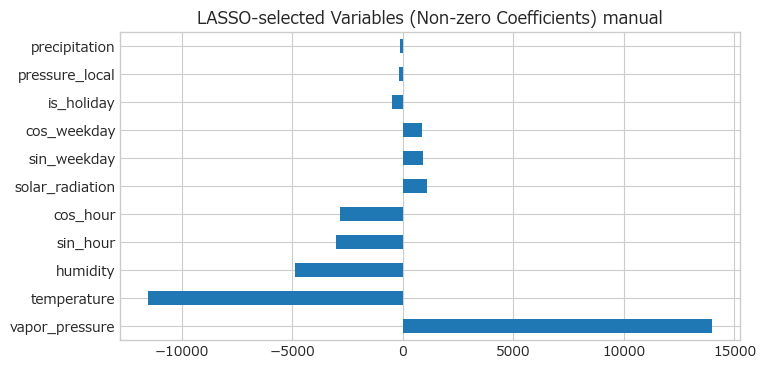

In [19]:
from sklearn.linear_model import Lasso
import pandas as pd 

# --- モデル再構築 ---
# alphaを手動で30に固定
lasso_manual = Lasso(alpha=alpha_new, random_state=0) 
lasso_manual.fit(X_scaled, y)

# --- 係数出力 ---
importance_manual = pd.Series(lasso_manual.coef_, index=feature_cols)

# 係数がゼロでない変数だけを選択
importance_manual = importance_manual[importance_manual != 0].sort_values(key=abs, ascending=False)
display(importance_manual)

# --- 変数の数を確認 ---
print(f"手動選択 (alpha={alpha_new}) で残った変数の数: {len(importance_manual)}")

# --- グラフ表示 ---
plt.figure(figsize=(8,4))
importance_manual.plot(kind='barh')
plt.title("LASSO-selected Variables (Non-zero Coefficients) manual")
plt.show()

In [20]:
print(importance_manual.index)

Index(['vapor_pressure', 'temperature', 'humidity', 'sin_hour', 'cos_hour',
       'solar_radiation', 'sin_weekday', 'cos_weekday', 'is_holiday',
       'pressure_local', 'precipitation'],
      dtype='object')


#### 6-3-2-4. LightGBM + SHAPによる特徴量重要度の評価

手動調整した$\alpha$でLASSOが選択した特徴量セットを用い、LightGBMとSHAPによる影響度評価を行う。

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 39360, number of used features: 11
[LightGBM] [Info] Start training from score 32039.445376


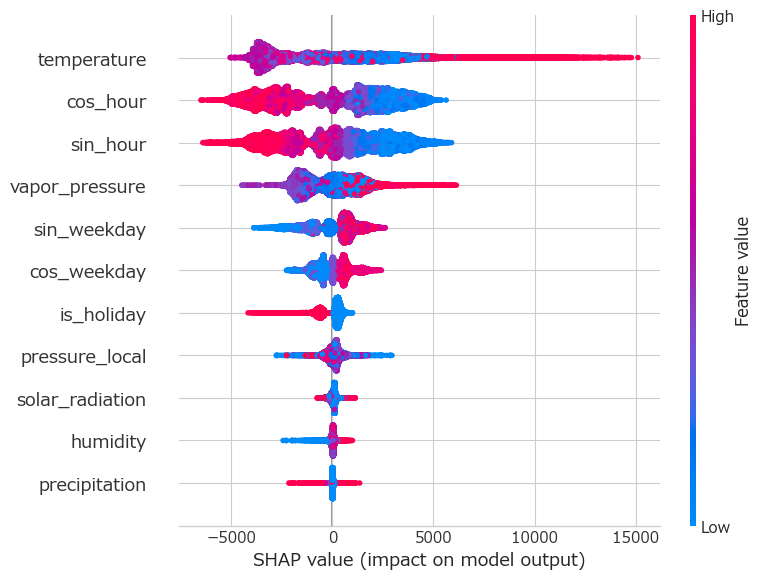

In [21]:
import pandas as pd
import lightgbm as lgb
import shap

# === 1. LASSOで選択された特徴量のみを抽出 ===
# importanceは係数が0でない変数のSeries
selected_features = importance_manual.index.tolist()
X_sel = X[selected_features]

# === 2. LightGBMモデルの学習 ===
model = lgb.LGBMRegressor(random_state=0)
model.fit(X_sel, y)

# === 3. SHAP解析と可視化（エラー修正版） ===
# Explainerをモデルのみで初期化します
explainer = shap.Explainer(model)

# SHAP値を計算します
shap_values = explainer(X_sel)

# SHAPのサマリープロットを表示します
# これで各変数が予測値に与える影響の大きさと方向がわかります
shap.summary_plot(shap_values, X_sel, show=True)

## 6-4. 結論

本ノートブックで実施した特徴量選択（LASSO + SHAP）の結果、それぞれの目的変数に対し、以下の変数が説明変数として有効であると判断した。

#### 1. 太陽光発電量（solar_gen_mw）の主要説明変数

（LASSO係数の絶対値が大きい順）
* `solar_radiation` (全天日射量)
* `cos_hour` (時間帯)
* `sunshine_duration` (日照時間)
* `temperature` (気温)
* `sin_hour` (時間帯)
* `pressure_local` (現地気圧)
* `precipitation` (降水量)
* `humidity` (湿度)
* `wind_speed` (風速)
* `sin_weekday` (曜日)

**考察**:
太陽光発電量は、物理法則に直接従うため、`solar_radiation`（全天日射量）が圧倒的に重要な特徴量となった。また、`cos_hour`や`sunshine_duration`も、日照の有無や長さを代理する変数として強く寄与しており、極めて直感的で妥当な結果である。

#### 2. 電力消費量（e_demand_mw）の主要説明変数

（手動選択 $\alpha=30$ でのLASSO係数の絶対値が大きい順）
* `vapor_pressure` (蒸気圧)
* `temperature` (気温)
* `humidity` (湿度)
* `sin_hour` (時間帯)
* `cos_hour` (時間帯)
* `solar_radiation` (全天日射量)
* `sin_weekday` (曜日)
* `cos_weekday` (曜日)
* `is_holiday` (休日フラグ)
* `pressure_local` (現地気圧)
* `precipitation` (降水量)

**考察**:
電力需要量は、人間の活動や快適性に起因するため、より複雑な要因が絡み合う。
- **冷暖房需要**: `temperature`（気温）と`humidity`（湿度）が上位に選択されたことは、冷暖房が電力需要の主要因であることを示している。
- **蒸気圧の重要性**: `vapor_pressure`（蒸気圧）が最も重要な変数として選択された。蒸気圧は「空気中に含まれる水蒸気の分圧」であり、気温と湿度の両方の情報を含んだ指標である。体感温度や不快指数と強い相関があるため、「蒸し暑さ」や「乾燥」といった人間の体感に近い指標として、単純な気温や湿度よりも強く電力需要（特に冷房）と結びついたと考えられる。
- **生活サイクル**: `sin/cos_hour`（時間帯）、`is_holiday`（休日フラグ）、`sin/cos_weekday`（曜日）が選択されたことは、人々の生活や経済活動のサイクルが電力需要パターンを形成する上で不可欠な要素であることを裏付けている。

#### 次工程への示唆
本工程で選択された特徴量セットは、物理的・人間的要因の両面から目的変数との強い関連性が確認できた。次工程では、これらの変数を用いてLightGBMなどの勾配ブースティングモデルを構築し、最終的な予測精度を評価・検証する。